In [70]:
import pandas as pd
from qutip import *
import numpy as np
import torch

In [85]:
def analyze(pulse_dir, U_target):
    pulses = pd.read_csv(pulse_dir)

    _I2_CPU = torch.eye(2, dtype=torch.cfloat)
    _SIGMA_X_CPU = torch.tensor([[0.0, 1.0], [1.0, 0.0]], dtype=torch.cfloat)
    _SIGMA_Y_CPU = torch.tensor([[0.0, -1.0j], [1.0j, 0.0]], dtype=torch.cfloat)
    _SIGMA_Z_CPU = torch.tensor([[1.0, 0.0], [0.0, -1.0]], dtype=torch.cfloat)

    pauli = [_I2_CPU, _SIGMA_X_CPU, _SIGMA_Y_CPU, _SIGMA_Z_CPU]

    def generate_unitary(pulse, delta, epsilon):
        Delta = pulse[1]
        Omega = pulse[2]
        phi = pulse[3]
        tau = pulse[4]

        H_base = (
            Delta* pauli[3]
            + Omega
            * (
                np.cos(phi) * pauli[1]
                + np.sin(phi) * pauli[2]
            )
        )

        H = H_base + delta * pauli[3]

        # U_k = exp(-i H_k t_k)
        return torch.linalg.matrix_exp(-1j * H * tau * (1 + epsilon))


    def spinor_to_bloch(psi: torch.Tensor) -> torch.Tensor:
        """
        Converts a spinor (2,) into a point on the Bloch sphere (3,).
        psi should be a normalized complex vector of shape (2,).
        """
        assert psi.shape == (2,), "psi must be a 2D complex vector"
        assert torch.is_complex(psi), "psi must be complex-valued"

        alpha, beta = psi[0], psi[1]
        x = 2 * torch.real(torch.conj(alpha) * beta)
        y = 2 * torch.imag(torch.conj(alpha) * beta)
        z = torch.abs(alpha)**2 - torch.abs(beta)**2

        return np.array([x, y, z])
    

    print(pulses.describe())


    bloch = Bloch()

    psi_init = torch.tensor([1, 0], dtype=torch.cfloat)
    bloch_sphere_vecs = [qutip.basis(2, 0)]
    bloch_3d_vec = [spinor_to_bloch(psi_init)]

    U_out = _I2_CPU
    evolution_time = 0

    for pulse in pulses.itertuples():
        U_step = generate_unitary(pulse, delta=0.5, epsilon=0.0)
        psi_init = U_step @ psi_init
        U_out = U_step @ U_out
        # _vec = spinor_to_bloch(psi_init)
        _vec = (
            qutip.Qobj([psi_init[0].item(), psi_init[1].item()], dims=[[2], [1]])
        ).unit()
        evolution_time += pulse[4]


        bloch_sphere_vecs.append(_vec)
        
        bloch_3d_vec.append(spinor_to_bloch(psi_init))

    bloch_3d_vec = np.array(bloch_3d_vec)
    x, y, z = bloch_3d_vec[:, 0], bloch_3d_vec[:, 1], bloch_3d_vec[:, 2]

    # Add points
    bloch.add_points([x, y, z])


    bloch.add_states(bloch_sphere_vecs[0])
    bloch.add_states(bloch_sphere_vecs[-1])


    # Add dashed lines manually
    for i in range(len(bloch_sphere_vecs) - 1):
        pt1 = bloch_sphere_vecs[i]
        pt2 = bloch_sphere_vecs[i+1]


        bloch.add_arc(
            pt1, pt2,
        )

    bloch.show()

    print(U_out)

    print(f"Total Evolution time: {evolution_time / np.pi} pi")

X(pi)
                0           1           2           3
count  100.000000  100.000000  100.000000  100.000000
mean     2.976850    0.996863    0.038945    0.105876
std      0.641252    0.012522    1.808758    0.042656
min      1.371399    0.886837   -3.135897    0.004417
25%      2.617532    0.998648   -1.468213    0.080550
50%      2.974550    0.999507    0.121511    0.104624
75%      3.387212    0.999864    1.571832    0.133797
max      4.596583    0.999996    3.141275    0.216534


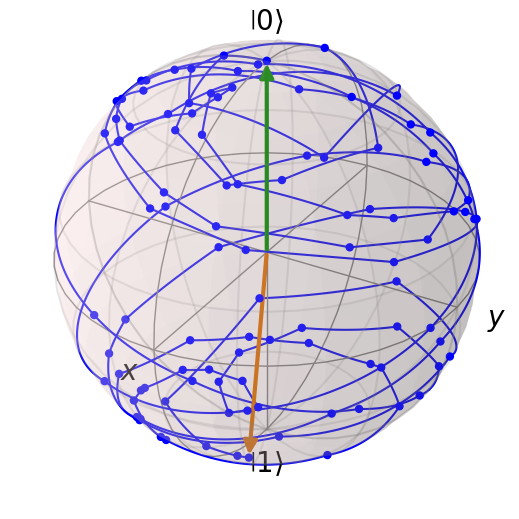

tensor([[ 0.0651+0.1638j, -0.1008+0.9791j],
        [ 0.1008+0.9791j,  0.0651-0.1638j]])
Total Evolution time: 3.3701358512861006 pi
X(pi-2)
                0           1           2           3
count  100.000000  100.000000  100.000000  100.000000
mean     3.005497    0.998467    0.097167    0.102248
std      0.658815    0.003872    1.822003    0.042730
min      1.356439    0.972484   -3.137307    0.004161
25%      2.606974    0.998928   -1.492650    0.074702
50%      3.019373    0.999586    0.100494    0.098533
75%      3.392100    0.999876    1.600022    0.131702
max      4.632353    0.999996    3.141349    0.214157


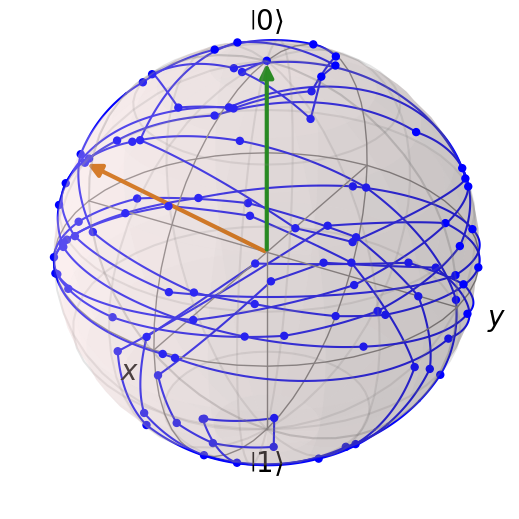

tensor([[-0.7847+0.1073j, -0.0358+0.6094j],
        [ 0.0358+0.6094j, -0.7847-0.1073j]])
Total Evolution time: 3.25465452747875 pi
Hadamard
                0           1           2           3
count  100.000000  100.000000  100.000000  100.000000
mean     3.054453    0.997815    0.059785    0.103665
std      0.677472    0.005674    1.781000    0.043866
min      1.386027    0.958863   -3.136138    0.006278
25%      2.635293    0.998733   -1.307305    0.076158
50%      3.066473    0.999426    0.092378    0.098298
75%      3.510247    0.999811    1.560716    0.135233
max      4.621171    0.999993    3.141004    0.220812


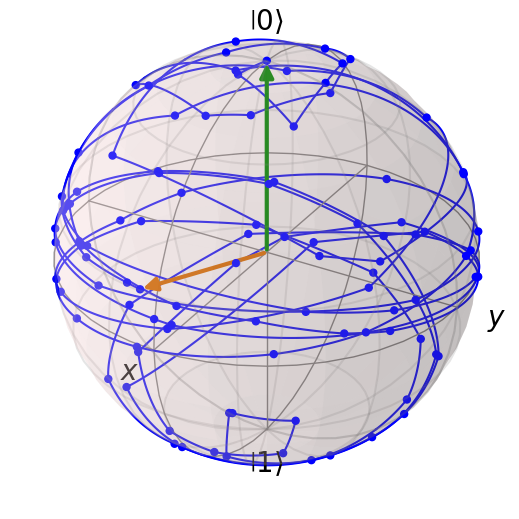

tensor([[ 0.0663+0.7925j, -0.1070+0.5966j],
        [ 0.1070+0.5966j,  0.0663-0.7925j]])
Total Evolution time: 3.299747823688913 pi
Z(pi-4)
                0           1           2           3
count  100.000000  100.000000  100.000000  100.000000
mean     2.999262    0.998499    0.159846    0.103097
std      0.705561    0.003654    1.861466    0.044769
min      1.313925    0.970611   -3.135876    0.004879
25%      2.525539    0.998939   -1.493451    0.071704
50%      3.008781    0.999550    0.297033    0.101210
75%      3.467353    0.999861    1.862730    0.129476
max      4.525876    0.999986    3.141074    0.215545


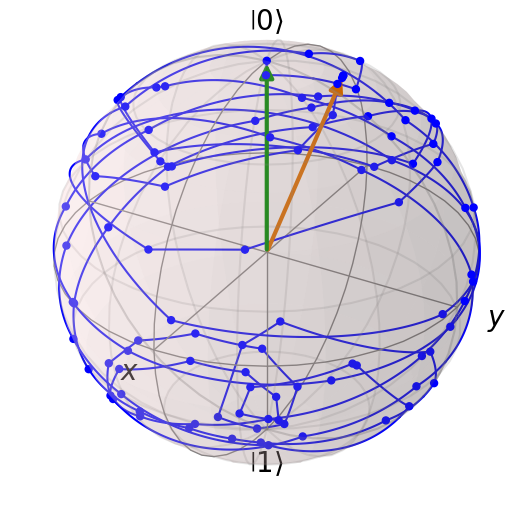

tensor([[-0.8891+0.4223j, -0.0019-0.1762j],
        [ 0.0019-0.1762j, -0.8891-0.4223j]])
Total Evolution time: 3.281665471148685 pi


In [ ]:
from run.single_qubit.single_qubit_script import *

U_targets = build_dataset()

U_target_names = [
    "X(pi)",
    "X(pi-2)",
    "Hadamard",
    "Z(pi-4)"
]


for U_target, name in zip(U_targets, U_target_names):
    pulse_dir = f"pulses/{name}_pulse.csv"
    print(name)
    analyze(pulse_dir, U_target)

In [ ]:
# X(pi)

U_target = np.array([[0, 1], [1, 0]])

pulse_dir = "pulses/X(pi)_pulse.csv"



pulses

,0,1,2,3
0,2.971277,0.999353,-0.370054,0.115060
1,2.760738,0.999071,0.615521,0.190045
2,2.790707,0.993635,1.088363,0.105200
3,2.775569,0.886837,-2.228889,0.042964
4,3.292843,0.954029,0.879183,0.141995
...,...,...,...,...
95,3.199315,0.997407,-1.338825,0.122817
96,3.422556,0.997575,-0.607630,0.164856
97,2.871815,0.998916,0.028936,0.086291
98,2.618267,0.997095,0.468693,0.040301


,0,1,2,3
count,100.000000,100.000000,100.000000,100.000000
mean,2.976850,0.996863,0.038945,0.105876
std,0.641252,0.012522,1.808758,0.042656
min,1.371399,0.886837,-3.135897,0.004417
25%,2.617532,0.998648,-1.468213,0.080550
50%,2.974550,0.999507,0.121511,0.104624
75%,3.387212,0.999864,1.571832,0.133797
max,4.596583,0.999996,3.141275,0.216534


In [74]:
pulse

Pandas(Index=99, _1=0.64630604, _2=0.7743179, _3=-3.0904193, _4=0.06982807)

In [75]:
qutip.basis(2, 0), qutip.basis(2, 1)

(Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[1.]
  [0.]],
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.]
  [1.]])

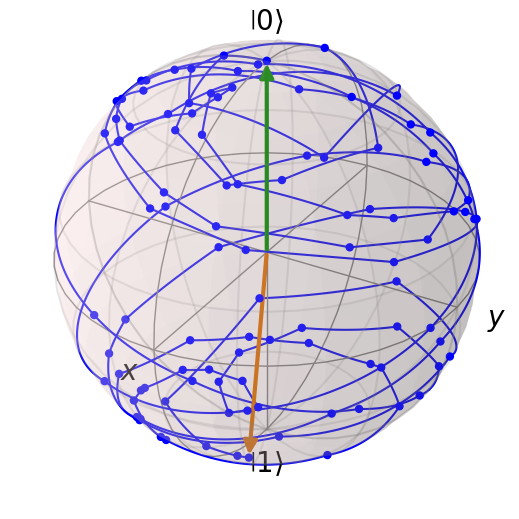

tensor([[ 0.0651+0.1638j, -0.1008+0.9791j],
        [ 0.1008+0.9791j,  0.0651-0.1638j]])
Total Evolution time: 3.3701358512861006 pi
